# TC Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import sys
import xarray as xr
import requests
from io import BytesIO
import numpy as np


sys.path.append("../../../functions")
from tcs import Extract_Circle
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from data_downloaders import  download_oni_index


In [3]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

In [4]:
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
tcs = download_ibtracs(url, basin = basin)

In [5]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns)

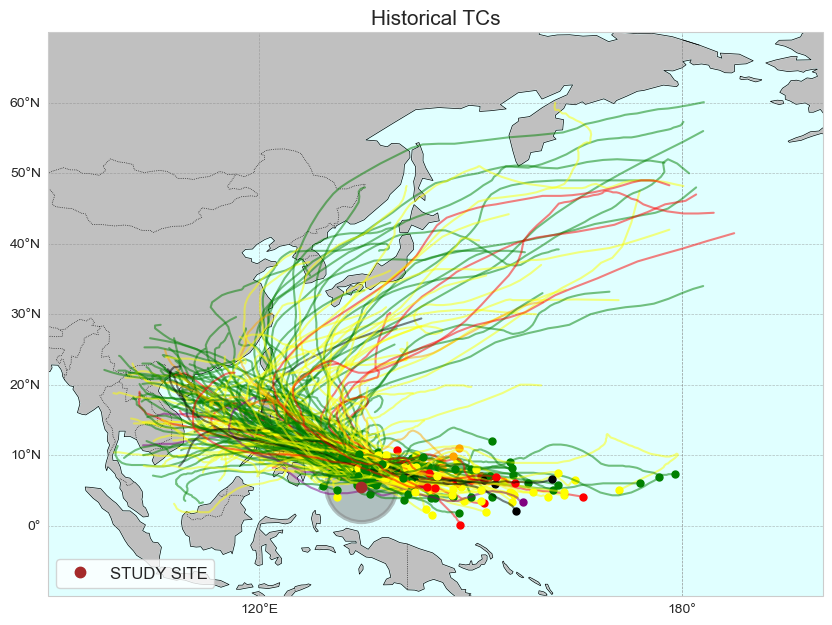

In [6]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel, tcs_sel_params.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)

## ONI index

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [7]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [61]:
oni = download_oni_index(p_data)

In [62]:
import pandas as pd
tcs_g = pd.DataFrame(tcs_sel.isel(date_time = 0).time.values)
tcs_g.index = tcs_g[0]
tcs_g.index = pd.DatetimeIndex(tcs_g.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)
tcs_g['ONI'] = oni.ONI

In [63]:
tcs_sel_params['ONI'] = (('storm'), tcs_g['ONI'].values)

In [73]:
lims = [-.5, .5]

In [74]:
oni['ONI_cat'] = np.where(oni.ONI < lims[0], -1, np.where(oni.ONI > lims[1], 1, 0))
tcs_sel_params['ONI_cat'] = (('storm'), np.where(tcs_sel.ONI < lims[0], -1, np.where(tcs_sel.ONI > lims[1], 1, 0)))

In [87]:
oni_perc_cat = oni.groupby('ONI_cat').size() / oni.shape[0] * 100
oni_perc_cat

ONI_cat
-1    27.027027
 0    46.509009
 1    26.463964
dtype: float64

In [88]:
tcs_perc_cat = tcs_sel_params.to_dataframe().groupby('ONI_cat').size() * 100 / tcs_sel_params.to_dataframe().shape[0]
tcs_perc_cat

ONI_cat
-1    30.693069
 0    50.495050
 1    18.811881
dtype: float64

In [96]:
#Relavice probability
tcs_perc_cat / oni_perc_cat

ONI_cat
-1    1.135644
 0    1.085705
 1    0.710849
dtype: float64

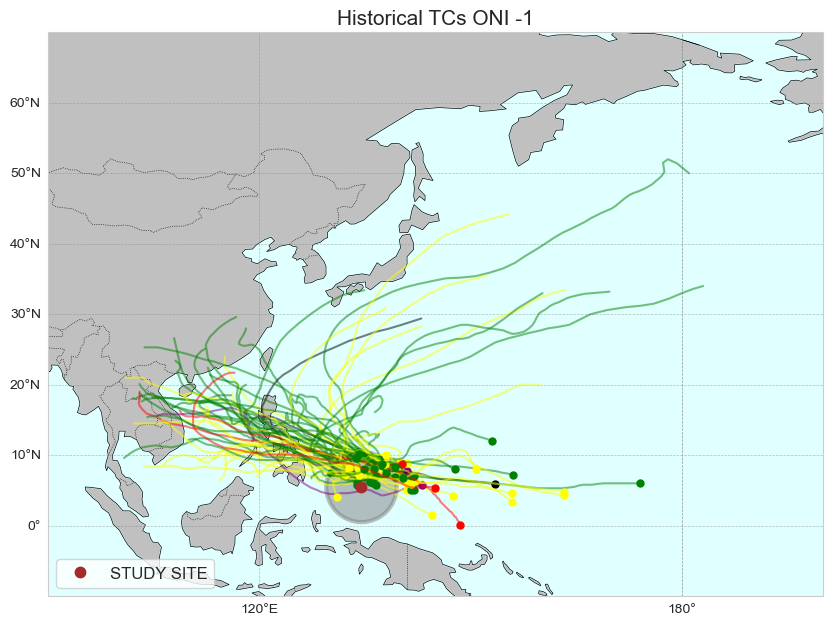

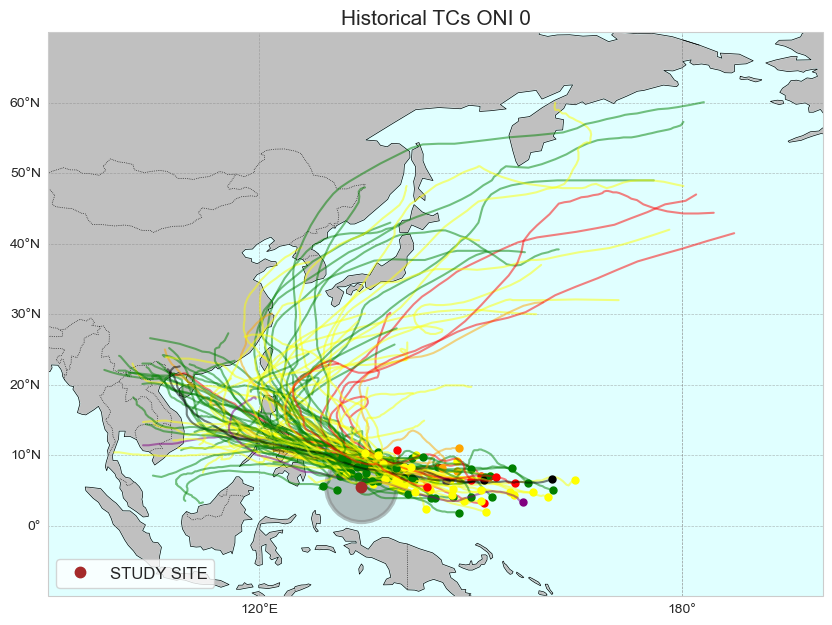

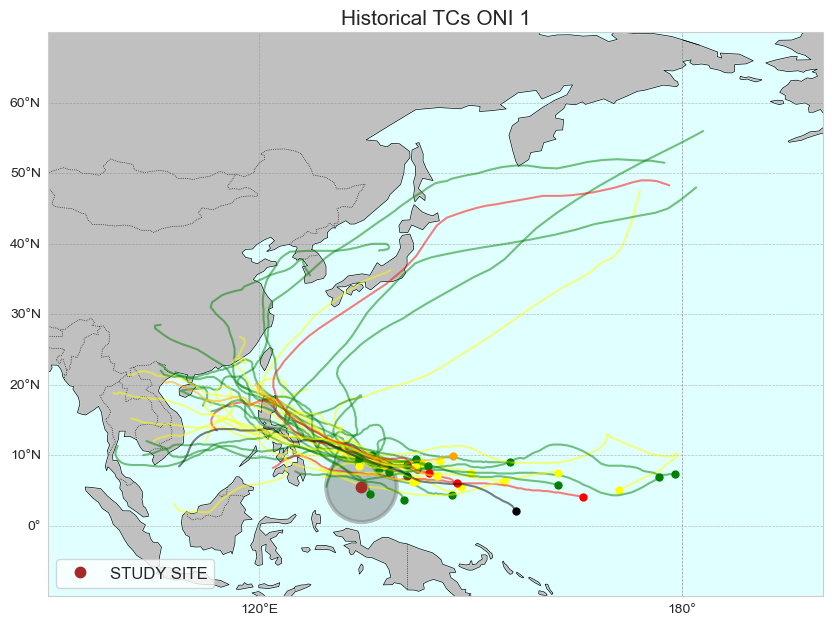

In [97]:
for category in [-1, 0, 1]:

    tcs_cat = tcs_sel.where(tcs_sel_params.ONI_cat == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.ONI_cat == category, drop = True)

    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs ONI {category}', fontsize=15)